# Finding the temporal autocorrelation order and evidence of slope
This notebook fits an ARIMA model for WESE data looking for evidence of change

In [1]:
# Load libraries
library(forecast); library(ggplot2);library(plyr); library(dplyr); library(fmsb); library(stats); 
library(lmtest); library(modelr)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [2]:
# Load the data
master<-read.csv("~/Workspace/Anthropocene/data/MASTER_SIE_MOD.csv")

In [3]:
#calculating the annual percentage change for WESE
master_gr <- master %>% mutate(growth_wese=log(WESE/lag(WESE)))%>% mutate(growth_wese_1=log(WESE_1/lag(WESE_1)))


In [4]:
master_gr<-subset(master_gr,year>2002 & year<2019)

In [5]:
head(master_gr)

,year,intP_RSP,mnChl_aw_RSP,mnOW_RSP,nmSST_aw_RSP,intP_MCM,mnChl_aw_MCM,mnOW_MCM,nmSST_aw_MCM,mnAirTemp,⋯,ADPE_CROZ,ADPE_RO,BIRD,EMPE,WESE,WESE_1,av_SIE,FIE,growth_wese,growth_wese_1
,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,2003,0.658810,1.278130,190735,-1.047010,0.1797500,0.2424260,2701.45,-1.177640,-4.625,⋯,100843,19630,22816,279,0.5084746,0.78,2.859,52.0,-0.05001038,-0.02531781
7,2004,0.659537,1.201000,268734,-0.546599,0.0595893,0.0920093,1115.63,-1.394120,-5.000,⋯,182492,20360,36773,475,0.2607562,0.35,2.759,14.9,-0.66782939,-0.80136077
8,2005,0.617897,1.116710,236044,-0.551816,0.2451990,0.5341190,3630.16,-1.099050,-5.250,⋯,194449,24590,57709,0,0.3780965,0.55,2.832,47.0,0.37156358,0.45198512
9,2006,0.673591,1.344420,218199,-0.970962,0.3927390,0.5908280,4718.94,-0.954533,-6.000,⋯,205667,26070,50326,359,0.5215124,0.95,2.738,47.0,0.32158360,0.54654371
10,2007,0.543325,1.170400,188097,-1.006890,0.3533950,0.6396110,3903.53,-1.064650,-6.800,⋯,197990,26540,50595,612,0.6518905,1.25,3.126,23.0,0.22314355,0.27443685
11,2008,0.525248,0.962226,241795,-0.846050,0.2566900,0.5890600,1968.25,-1.173800,-5.025,⋯,193624,18050,39285,367,0.5215124,0.75,3.167,20.0,-0.22314355,-0.51082562


In [6]:
master_gr$mnOW_MCM6<- master_gr$mnOW_MCM/10^3

In [7]:
#lag 5 years SIE
master_gr <- master_gr %>% mutate(SIE_lag5 = lag(av_SIE,5))
master_gr[5,"SIE_lag5"]<-2.703
master_gr[4,"SIE_lag5"]<-3.123
master_gr[3,"SIE_lag5"]<-2.731
master_gr[2,"SIE_lag5"]<-2.767
master_gr[1,"SIE_lag5"]<-2.60

#lag 4 years SIE
master_gr <- master_gr %>% mutate(SIE_lag4 = lag(av_SIE,4))
master_gr[4,"SIE_lag4"]<-2.703
master_gr[3,"SIE_lag4"]<-3.123
master_gr[2,"SIE_lag4"]<-2.731
master_gr[1,"SIE_lag4"]<-2.767


#lag 4 years Gyre
master_gr <- master_gr %>% mutate(GyreSPD_lag4 = lag(GyreSPD,4))
master_gr[4,"GyreSPD_lag4"]<-6.2
master_gr[3,"GyreSPD_lag4"]<-6.3
master_gr[2,"GyreSPD_lag4"]<-5.7
master_gr[1,"GyreSPD_lag4"]<-5.8

#lag 5 years Gyre
master_gr <- master_gr %>% mutate(GyreSPD_lag5 = lag(GyreSPD,5))
master_gr[5,"GyreSPD_lag5"]<-6.2
master_gr[4,"GyreSPD_lag5"]<-6.3
master_gr[3,"GyreSPD_lag5"]<-5.7
master_gr[2,"GyreSPD_lag5"]<-5.8
master_gr[1,"GyreSPD_lag5"]<-5.0

#lag 5 years Air Temp
master_gr <- master_gr %>% mutate(mnAirTemp_lag5 = lag(mnAirTemp,5))
master_gr[5,"mnAirTemp_lag5"]<--5.6
master_gr[4,"mnAirTemp_lag5"]<--4.5
master_gr[3,"mnAirTemp_lag5"]<--5.2
master_gr[2,"mnAirTemp_lag5"]<--7.7
master_gr[1,"mnAirTemp_lag5"]<--4.2

#lag 4 years Air Temp
master_gr <- master_gr %>% mutate(mnAirTemp_lag4 = lag(mnAirTemp,4))
master_gr[5,"mnAirTemp_lag4"]<--5.6
master_gr[4,"mnAirTemp_lag4"]<--4.5
master_gr[3,"mnAirTemp_lag4"]<--5.2
master_gr[2,"mnAirTemp_lag4"]<--7.7


#lag 4 years FIE
master_gr <- master_gr %>% mutate(FIE_lag6 = lag(FIE,6))


# VARIABLES WITHOUT DATA FOR THE LAGGED YEARS (before 1998)

master_gr <- master_gr %>% mutate(mnWind_lag = lag(mnWind,5))
master_gr <- master_gr %>% mutate(Salinity_lag = lag(Salinity,5))
master_gr <- master_gr %>% mutate(mnSST_lag = lag(nmSST_aw_RSP,5))
master_gr <- master_gr %>% mutate(Prop134_lag = lag(Prop._134,5))
master_gr <- master_gr %>% mutate(FIE_lag4 = lag(FIE,4))


In [8]:
# Quadratic variables
master_gr$FIE_2<- master_gr$FIE^2
master_gr$FIE_lag4_2<- master_gr$FIE_lag4^2
master_gr$SIE_lag4_2<- master_gr$SIE_lag4^2
master_gr$SIE_2<- master_gr$mnSIE^2
master_gr$mnAirTemp_2<- master_gr$mnAirTemp^2
master_gr$SIE_lag5_2<- master_gr$SIE_lag5^2
master_gr$mnOW_RSP6<- master_gr$mnOW_RSP/10^3
master_gr$mnOW_MCM6<- master_gr$mnOW_MCM/10^3
master_gr$mnOW_RSP6_2<-master_gr$mnOW_RSP6^2
master_gr$mnOW_MCM6_2<-master_gr$mnOW_MCM6^2
master_gr$mnChl_aw_RSP_2<-master_gr$mnChl_aw_RSP^2
master_gr$nmSST_aw_RSP_2<-master_gr$nmSST_aw_RSP^2
master_gr$mnWind_2<-master_gr$mnWind^2
master_gr$GyreSPD_2<-master_gr$GyreSPD^2
master_gr$GyreSPD_lag4_2<-master_gr$GyreSPD_lag4^2
master_gr$GyreSPD_lag5_2<-master_gr$GyreSPD_lag5^2
master_gr$Salinity_2<-master_gr$Salinity^2
master_gr$intP_RSP_2<-master_gr$intP_RSP^2
master_gr$Prop._134_2<-master_gr$Prop._134^2
master_gr$TOTALTonnes.100_2<-master_gr$TOTALTonnes.100^2
master_gr$mnSIE_2<- master_gr$mnSIE^2
master_gr$mnAirTemp_2<- master_gr$mnAirTemp^2

In [9]:
head(master_gr)


,year,intP_RSP,mnChl_aw_RSP,mnOW_RSP,nmSST_aw_RSP,intP_MCM,mnChl_aw_MCM,mnOW_MCM,nmSST_aw_MCM,mnAirTemp,⋯,nmSST_aw_RSP_2,mnWind_2,GyreSPD_2,GyreSPD_lag4_2,GyreSPD_lag5_2,Salinity_2,intP_RSP_2,Prop._134_2,TOTALTonnes.100_2,mnSIE_2
,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2003,0.658810,1.278130,190735,-1.047010,0.1797500,0.2424260,2701.45,-1.177640,-4.625,⋯,1.0962299,73.96,49.00,33.64,25.00,1213.547,0.4340306,3025,201.0923,8.173881
2,2004,0.659537,1.201000,268734,-0.546599,0.0595893,0.0920093,1115.63,-1.394120,-5.000,⋯,0.2987705,70.56,51.84,32.49,33.64,1213.477,0.4349891,1225,426.2491,7.612081
3,2005,0.617897,1.116710,236044,-0.551816,0.2451990,0.5341190,3630.16,-1.099050,-5.250,⋯,0.3045009,77.44,60.84,39.69,32.49,1210.692,0.3817967,1444,1125.8508,8.020224
4,2006,0.673591,1.344420,218199,-0.970962,0.3927390,0.5908280,4718.94,-0.954533,-6.000,⋯,0.9427672,77.44,29.16,38.44,39.69,1211.040,0.4537248,2025,729.6968,7.496644
5,2007,0.543325,1.170400,188097,-1.006890,0.3533950,0.6396110,3903.53,-1.064650,-6.800,⋯,1.0138275,88.36,24.01,49.00,38.44,NA,0.2952021,1764,814.4232,9.771876
6,2008,0.525248,0.962226,241795,-0.846050,0.2566900,0.5890600,1968.25,-1.173800,-5.025,⋯,0.7158006,67.24,54.76,51.84,49.00,1212.432,0.2758855,1681,500.7257,10.029889


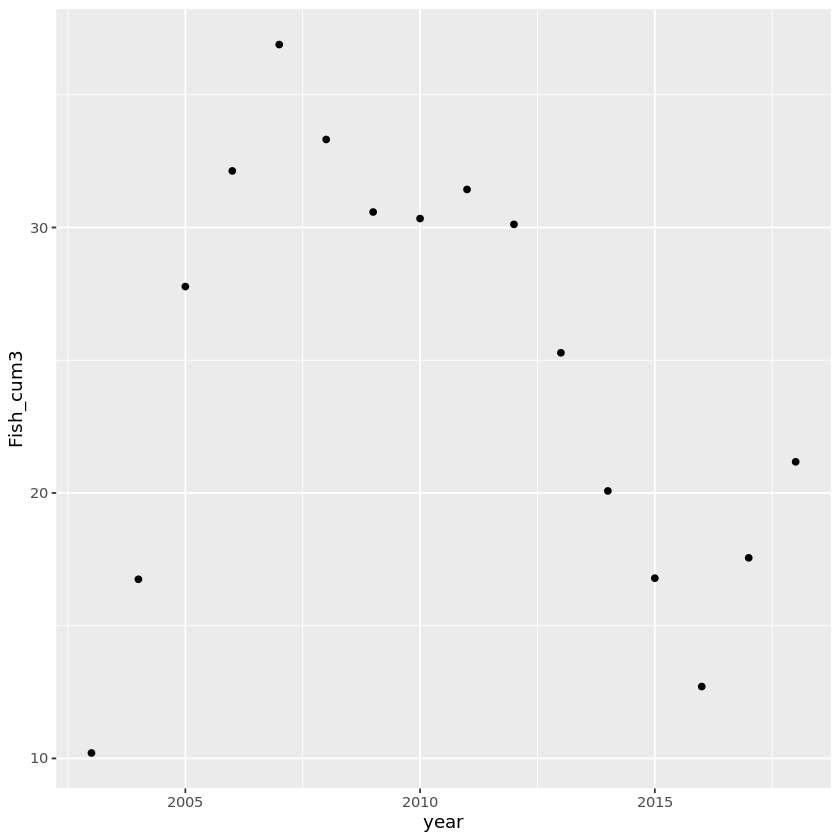

In [10]:
ggplot(master_gr, aes(x=year, y= Fish_cum3))+geom_point()

# Arima model with growth_wese

In [11]:
#checking best model
mdl1<-Arima(master_gr$growth_wese,order=c(1,0,0),include.mean=F,include.drift=F)
summary(mdl1)

Series: master_gr$growth_wese 
ARIMA(1,0,0) with zero mean 

Coefficients:
          ar1
      -0.3381
s.e.   0.2484

sigma^2 estimated as 0.08219:  log likelihood=-2.26
AIC=8.52   AICc=9.44   BIC=10.06

Training set error measures:
                     ME      RMSE       MAE      MPE     MAPE      MASE
Training set 0.02013582 0.2775849 0.2133557 123.3987 123.3987 0.6292148
                    ACF1
Training set -0.08687543



	Ljung-Box test

data:  Residuals from ARIMA(1,0,0) with zero mean
Q* = 2.3657, df = 3, p-value = 0.5001

Model df: 1.   Total lags used: 4



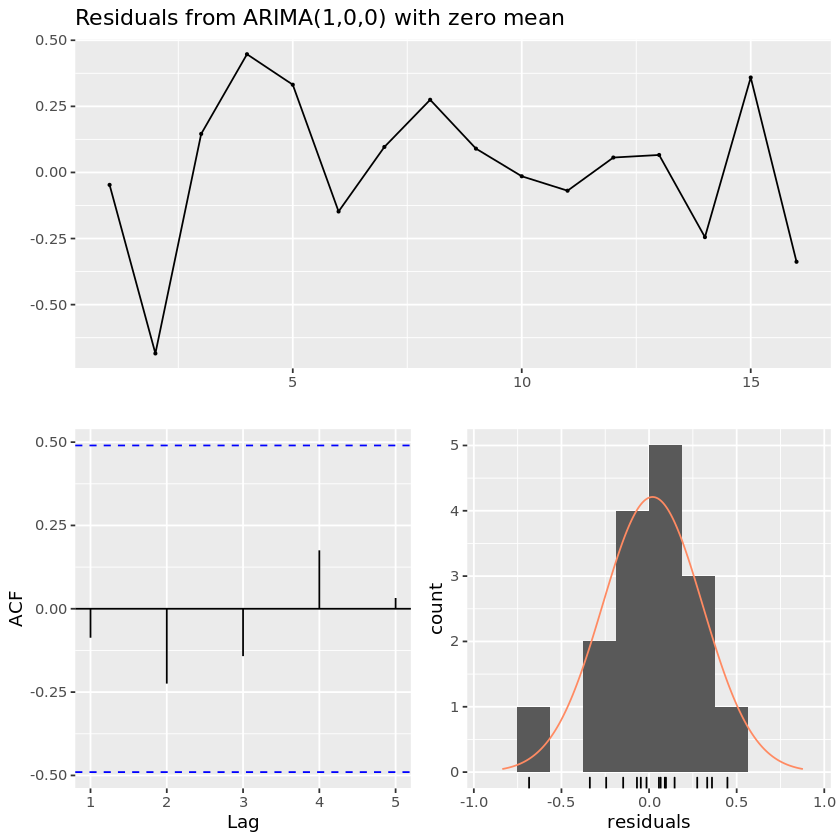

In [12]:
checkresiduals(mdl1)

### NOTE that the use of an ARIMA model is not justified
There seem to be no significant autocorrelation effects. From here down we use a regression model.

In [13]:
#threshold at 10 (it’s equivalent to explaining 99% of the information in a variable by the set of the other covariates).

#select covariates based on variance inflation

in_frame <- master_gr %>% select (FIE, mnWind, nmSST_aw_MCM, Fish_cum3, mnAirTemp, mnOW_MCM6)

vif_func<-function(in_frame,thresh=10,trace=T,...){
  
  
  
  if(class(in_frame) != 'data.frame') in_frame<-data.frame(in_frame)
  
  
  
  #get initial vif value for all comparisons of variables
  
  vif_init<-NULL
  
  var_names <- names(in_frame)
  
  for(val in var_names){
    
    regressors <- var_names[-which(var_names == val)]
    
    form <- paste(regressors, collapse = '+')
    
    form_in <- formula(paste(val, '~', form))
    
    vif_init<-rbind(vif_init, c(val, VIF(lm(form_in, data = in_frame, ...))))
    
  }
  
  vif_max<-max(as.numeric(vif_init[,2]), na.rm = TRUE)
  
  
  
  if(vif_max < thresh){
    
    if(trace==T){ #print output of each iteration
      
      prmatrix(vif_init,collab=c('var','vif'),rowlab=rep('',nrow(vif_init)),quote=F)
      
      cat('\n')
      
      cat(paste('All variables have VIF < ', thresh,', max VIF ',round(vif_max,2), sep=''),'\n\n')
      
    }
    
    return(var_names)
    
  }
  
  else{
    
    
    
    in_dat<-in_frame
    
    
    
    #backwards selection of explanatory variables, stops when all VIF values are below 'thresh'
    
    while(vif_max >= thresh){
      
      
      
      vif_vals<-NULL
      
      var_names <- names(in_dat)
      
      
      
      for(val in var_names){
        
        regressors <- var_names[-which(var_names == val)]
        
        form <- paste(regressors, collapse = '+')
        
        form_in <- formula(paste(val, '~', form))
        
        vif_add<-VIF(lm(form_in, data = in_dat, ...))
        
        vif_vals<-rbind(vif_vals,c(val,vif_add))
        
      }
      
      max_row<-which(vif_vals[,2] == max(as.numeric(vif_vals[,2]), na.rm = TRUE))[1]
      
      
      
      vif_max<-as.numeric(vif_vals[max_row,2])
      
      
      
      if(vif_max<thresh) break
      
      
      
      if(trace==T){ #print output of each iteration
        
        prmatrix(vif_vals,collab=c('var','vif'),rowlab=rep('',nrow(vif_vals)),quote=F)
        
        cat('\n')
        
        cat('removed: ',vif_vals[max_row,1],vif_max,'\n\n')
        
        flush.console()
        
      }
      
      
      
      in_dat<-in_dat[,!names(in_dat) %in% vif_vals[max_row,1]]
      
      
      
    }
    
    
    
    return(names(in_dat))
    
    
    
  }
  
  
  
}
  
vif_func(in_frame,thresh=10,trace=T)

 var          vif             
 FIE          1.8613986000153 
 mnWind       4.00772426706111
 nmSST_aw_MCM 5.74833057791949
 Fish_cum3    2.60333655850395
 mnAirTemp    1.36479382717309
 mnOW_MCM6    10.815955188567 

removed:  mnOW_MCM6 10.81596 



[1] "FIE"          "mnWind"       "nmSST_aw_MCM" "Fish_cum3"    "mnAirTemp"

# Fish variables

In [14]:
# Fish_cum3= cumulative 3 years (no weights)
# Fish_cum_8_9_1= 3 years with weights (80%, 90% and 100%)
# Fish_cum_6_8_1= 3 years with weights (60%, 80% and 100%)
# Fish_cum2= cumulative 2 years (no weights)
# Fish_cum_75_1= 2 years with weights (75% and 100%)
# Fish_cum_5_1= 2 years with weights (50% and 100%)
# Fish_cum_2_1= 2 years with weights (20% and 100%)

In [15]:
#Saturated model

model_wese<- lm(growth_wese~ FIE+ mnWind + nmSST_aw_MCM + Fish_cum3 + mnAirTemp +  mnOW_MCM6, data=master_gr)

In [16]:
summary(model_wese); paste("AIC:",AIC(model_wese))


Call:
lm(formula = growth_wese ~ FIE + mnWind + nmSST_aw_MCM + Fish_cum3 + 
    mnAirTemp + mnOW_MCM6, data = master_gr)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.19164 -0.13320  0.01736  0.11230  0.18859 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept)  -0.330197   0.780564  -0.423   0.6822  
FIE           0.010442   0.004068   2.567   0.0303 *
mnWind       -0.148211   0.098992  -1.497   0.1686  
nmSST_aw_MCM -0.204287   0.585192  -0.349   0.7350  
Fish_cum3     0.003942   0.009197   0.429   0.6783  
mnAirTemp    -0.073455   0.081044  -0.906   0.3884  
mnOW_MCM6     0.189035   0.127080   1.488   0.1710  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1797 on 9 degrees of freedom
Multiple R-squared:  0.7899,	Adjusted R-squared:  0.6498 
F-statistic: 5.639 on 6 and 9 DF,  p-value: 0.01097


[1] "AIC: -2.73494514806318"

In [17]:
master_gr[,c("year","FIE", "GyreSPD", "mnWind", "nmSST_aw_MCM" ,"Fish_cum3", "Fish_cum_6_8_1", "Fish_cum_75_1", "mnAirTemp", "mnOW_MCM6")]

year,FIE,GyreSPD,mnWind,nmSST_aw_MCM,Fish_cum3,Fish_cum_6_8_1,Fish_cum_75_1,mnAirTemp,mnOW_MCM6
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2003,52.0,7.0,8.6,-1.177640,10.20478,9.587261,9.091788,-4.625,2.70145
2004,14.9,7.2,8.4,-1.394120,16.74862,14.499460,13.075569,-5.000,1.11563
2005,47.0,7.8,8.8,-1.099050,27.77582,23.210861,18.169929,-5.250,3.63016
2006,47.0,5.4,8.8,-0.954533,32.13224,26.691748,21.718609,-6.000,4.71894
2007,23.0,4.9,9.4,-1.064650,36.89221,29.360890,21.102856,-6.800,3.90353
2008,20.0,7.4,8.2,-1.173800,33.31634,26.056814,18.164030,-5.025,1.96825
2009,38.0,6.1,9.2,-0.939651,30.58369,23.954386,16.304059,-5.475,5.00304
2010,18.0,7.8,8.8,-0.910408,30.33708,24.782637,18.806762,-4.800,4.67662
2011,18.0,5.6,8.6,-1.145310,31.43484,25.317699,19.076832,-4.475,3.44675


In [18]:
step(model_wese)

Start:  AIC=-50.14
growth_wese ~ FIE + mnWind + nmSST_aw_MCM + Fish_cum3 + mnAirTemp + 
    mnOW_MCM6

               Df Sum of Sq     RSS     AIC
- nmSST_aw_MCM  1  0.003933 0.29441 -51.926
- Fish_cum3     1  0.005928 0.29641 -51.818
- mnAirTemp     1  0.026514 0.31699 -50.743
<none>                      0.29048 -50.141
- mnOW_MCM6     1  0.071417 0.36190 -48.624
- mnWind        1  0.072350 0.36283 -48.583
- FIE           1  0.212659 0.50314 -43.352

Step:  AIC=-51.93
growth_wese ~ FIE + mnWind + Fish_cum3 + mnAirTemp + mnOW_MCM6

            Df Sum of Sq     RSS     AIC
- mnAirTemp  1   0.02293 0.31734 -52.726
- Fish_cum3  1   0.02373 0.31815 -52.685
<none>                   0.29441 -51.926
- mnWind     1   0.10269 0.39711 -49.138
- mnOW_MCM6  1   0.22272 0.51713 -44.913
- FIE        1   0.41362 0.70803 -39.886

Step:  AIC=-52.73
growth_wese ~ FIE + mnWind + Fish_cum3 + mnOW_MCM6

            Df Sum of Sq     RSS     AIC
- Fish_cum3  1   0.03425 0.35159 -53.086
<none>                


Call:
lm(formula = growth_wese ~ FIE + mnWind + mnOW_MCM6, data = master_gr)

Coefficients:
(Intercept)          FIE       mnWind    mnOW_MCM6  
    0.42764      0.01053     -0.15221      0.17973  


In [19]:
#trying model above
model_wese<- lm(formula = growth_wese ~ FIE + mnWind + mnOW_MCM6, data = master_gr)
summary (model_wese); paste("AIC:",AIC(model_wese))


Call:
lm(formula = growth_wese ~ FIE + mnWind + mnOW_MCM6, data = master_gr)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.20428 -0.15388  0.03637  0.11878  0.28260 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept)  0.427640   0.475621   0.899  0.38628   
FIE          0.010526   0.002911   3.616  0.00354 **
mnWind      -0.152212   0.058779  -2.590  0.02368 * 
mnOW_MCM6    0.179734   0.045478   3.952  0.00192 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1712 on 12 degrees of freedom
Multiple R-squared:  0.7457,	Adjusted R-squared:  0.6821 
F-statistic: 11.73 on 3 and 12 DF,  p-value: 0.0007018


[1] "AIC: -5.68013503342124"

In [20]:
#Including Fish cum
model_wese<- lm(formula = growth_wese ~ FIE + mnWind + Fish_cum3 + mnOW_MCM6, data = master_gr)
summary (model_wese); paste("AIC:",AIC(model_wese))



Call:
lm(formula = growth_wese ~ FIE + mnWind + Fish_cum3 + mnOW_MCM6, 
    data = master_gr)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.170399 -0.144717  0.001645  0.120113  0.193478 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept)  0.057114   0.581711   0.098  0.92355   
FIE          0.011381   0.002993   3.803  0.00293 **
mnWind      -0.120092   0.065353  -1.838  0.09326 . 
Fish_cum3    0.007105   0.006521   1.090  0.29920   
mnOW_MCM6    0.147955   0.053732   2.754  0.01877 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1698 on 11 degrees of freedom
Multiple R-squared:  0.7704,	Adjusted R-squared:  0.687 
F-statistic:  9.23 on 4 and 11 DF,  p-value: 0.0016


[1] "AIC: -5.31993041081639"

In [21]:
# Including Gyre
model_wese<- lm(formula = growth_wese ~ FIE + mnWind + Fish_cum3 + mnOW_MCM6 + GyreSPD, data = master_gr)
summary (model_wese); paste("AIC:",AIC(model_wese))


Call:
lm(formula = growth_wese ~ FIE + mnWind + Fish_cum3 + mnOW_MCM6 + 
    GyreSPD, data = master_gr)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.20012 -0.08440  0.01108  0.10239  0.16174 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept) -1.353959   0.824473  -1.642  0.13496   
FIE          0.010362   0.002717   3.814  0.00413 **
mnWind       0.017528   0.093077   0.188  0.85481   
Fish_cum3    0.009759   0.006008   1.624  0.13879   
mnOW_MCM6    0.124051   0.052387   2.368  0.04205 * 
GyreSPD      0.039276   0.047008   0.836  0.42505   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1513 on 9 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.816,	Adjusted R-squared:  0.7139 
F-statistic: 7.985 on 5 and 9 DF,  p-value: 0.00398


[1] "AIC: -7.74983086549227"

In [22]:
#trying ALL FISH_CUM. BEST MODEL?  Best model is with Fish_cum3
model_wese<- lm(formula = growth_wese ~ FIE + mnWind + Fish_cum3 + mnOW_MCM6 + GyreSPD, data = master_gr)
summary (model_wese); paste("AIC:",AIC(model_wese))


Call:
lm(formula = growth_wese ~ FIE + mnWind + Fish_cum3 + mnOW_MCM6 + 
    GyreSPD, data = master_gr)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.20012 -0.08440  0.01108  0.10239  0.16174 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept) -1.353959   0.824473  -1.642  0.13496   
FIE          0.010362   0.002717   3.814  0.00413 **
mnWind       0.017528   0.093077   0.188  0.85481   
Fish_cum3    0.009759   0.006008   1.624  0.13879   
mnOW_MCM6    0.124051   0.052387   2.368  0.04205 * 
GyreSPD      0.039276   0.047008   0.836  0.42505   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1513 on 9 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.816,	Adjusted R-squared:  0.7139 
F-statistic: 7.985 on 5 and 9 DF,  p-value: 0.00398


[1] "AIC: -7.74983086549227"

In [23]:
test <- cor.test(master_gr$FIE, master_gr$mnOW_MCM6, method= "spearman")
test


Warning message in cor.test.default(master_gr$FIE, master_gr$mnOW_MCM6, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  master_gr$FIE and master_gr$mnOW_MCM6
S = 668.93, p-value = 0.9523
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.0162846 


# BEST MODEL
The model below is the best model we found. At the bottom we do a likelihood ratio test to justify the exclusion of wind effects in the model. We also fit reduced models from this one, one variable at the time.

In [24]:
# Top model
top_model_wese<- lm(formula = growth_wese ~ FIE + mnOW_MCM6 + GyreSPD + Fish_cum3, data = master_gr)
summary (top_model_wese); paste("AIC:",AIC(top_model_wese))
logLik(top_model_wese)


Call:
lm(formula = growth_wese ~ FIE + mnOW_MCM6 + GyreSPD + Fish_cum3, 
    data = master_gr)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.195570 -0.087610 -0.003034  0.103752  0.161810 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept) -1.218671   0.384500  -3.169  0.01000 **
FIE          0.010307   0.002568   4.014  0.00246 **
mnOW_MCM6    0.130653   0.037001   3.531  0.00544 **
GyreSPD      0.040298   0.044385   0.908  0.38528   
Fish_cum3    0.009370   0.005364   1.747  0.11125   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1438 on 10 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.8153,	Adjusted R-squared:  0.7415 
F-statistic: 11.04 on 4 and 10 DF,  p-value: 0.00109


[1] "AIC: -9.6908445481179"

'log Lik.' 10.84542 (df=6)

In [25]:
# No FIE
model_wese<- lm(formula = growth_wese ~ mnOW_MCM6 + GyreSPD + Fish_cum3, data = master_gr)
summary (model_wese); paste("AIC:",AIC(model_wese))
logLik(model_wese)


Call:
lm(formula = growth_wese ~ mnOW_MCM6 + GyreSPD + Fish_cum3, data = master_gr)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.29674 -0.11415  0.01076  0.11935  0.45285 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept) -1.114810   0.591101  -1.886   0.0860 .
mnOW_MCM6    0.164768   0.055487   2.969   0.0128 *
GyreSPD      0.064735   0.067743   0.956   0.3598  
Fish_cum3    0.005601   0.008137   0.688   0.5055  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2216 on 11 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.5177,	Adjusted R-squared:  0.3862 
F-statistic: 3.936 on 3 and 11 DF,  p-value: 0.03929


[1] "AIC: 2.70814759538535"

'log Lik.' 3.645926 (df=5)

In [26]:
# No mean Open Water at McMurdo Sound (lag 6 yrs)
model_wese<- lm(formula = growth_wese ~ FIE + GyreSPD + Fish_cum3, data = master_gr)
summary (model_wese); paste("AIC:",AIC(model_wese))
logLik(model_wese)


Call:
lm(formula = growth_wese ~ FIE + GyreSPD + Fish_cum3, data = master_gr)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.41614 -0.06710  0.02665  0.09690  0.22688 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept) -0.733096   0.513179  -1.429  0.18091   
FIE          0.012389   0.003571   3.469  0.00525 **
GyreSPD      0.004572   0.061765   0.074  0.94232   
Fish_cum3    0.015756   0.007217   2.183  0.05158 . 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2055 on 11 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.5851,	Adjusted R-squared:  0.4719 
F-statistic:  5.17 on 3 and 11 DF,  p-value: 0.018


[1] "AIC: 0.452156159992603"

'log Lik.' 4.773922 (df=5)

In [27]:
# No Gyre speed
model_wese<- lm(formula = growth_wese ~ FIE + mnOW_MCM6 + Fish_cum3, data = master_gr)
summary (model_wese); paste("AIC:",AIC(model_wese))
logLik(model_wese)


Call:
lm(formula = growth_wese ~ FIE + mnOW_MCM6 + Fish_cum3, data = master_gr)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.3742 -0.1185  0.0545  0.1341  0.2097 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.954267   0.206126  -4.630 0.000581 ***
FIE          0.013039   0.003123   4.175 0.001289 ** 
mnOW_MCM6    0.080419   0.042904   1.874 0.085417 .  
Fish_cum3    0.012510   0.006370   1.964 0.073132 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1859 on 12 degrees of freedom
Multiple R-squared:    0.7,	Adjusted R-squared:  0.625 
F-statistic: 9.332 on 3 and 12 DF,  p-value: 0.001843


[1] "AIC: -3.03648266776172"

'log Lik.' 6.518241 (df=5)

In [28]:
# No cumulative Fish effects
model_wese<- lm(formula = growth_wese ~ FIE + mnOW_MCM6 + GyreSPD, data = master_gr)
summary (model_wese); paste("AIC:",AIC(model_wese))
logLik(model_wese)


Call:
lm(formula = growth_wese ~ FIE + mnOW_MCM6 + GyreSPD, data = master_gr)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.21413 -0.14426  0.04833  0.10110  0.21715 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept) -0.898510   0.368180  -2.440  0.03280 * 
FIE          0.009522   0.002754   3.458  0.00535 **
mnOW_MCM6    0.152446   0.037943   4.018  0.00202 **
GyreSPD      0.018453   0.046388   0.398  0.69840   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1567 on 11 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.759,	Adjusted R-squared:  0.6932 
F-statistic: 11.55 on 3 and 11 DF,  p-value: 0.001005


[1] "AIC: -7.69610081940068"

'log Lik.' 8.84805 (df=5)

In [29]:
# Top model as ARIMA
cov_sat_growth_top<-as.matrix(master_gr[,c("FIE", "Fish_cum3", "mnOW_MCM6", "GyreSPD")]) 
mdlTop<-Arima(master_gr$growth_wese,order=c(1,0,0),include.mean=F,include.drift=F,xreg= cov_sat_growth_top)
summary(mdlTop)
coeftest(mdlTop)

Series: master_gr$growth_wese 
Regression with ARIMA(1,0,0) errors 

Coefficients:
          ar1     FIE  Fish_cum3  mnOW_MCM6  GyreSPD
      -0.3849  0.0095     0.0012     0.1039  -0.0955
s.e.   0.2606  0.0027     0.0042     0.0350   0.0190

sigma^2 estimated as 0.03621:  log likelihood=6.57
AIC=-1.13   AICc=9.37   BIC=3.12

Training set error measures:
                      ME      RMSE       MAE      MPE     MAPE      MASE
Training set -0.01006786 0.1553662 0.1198774 102.9865 124.9582 0.3535347
                    ACF1
Training set -0.06893918



z test of coefficients:

            Estimate Std. Error z value  Pr(>|z|)    
ar1       -0.3849339  0.2605860 -1.4772 0.1396258    
FIE        0.0094909  0.0027032  3.5110 0.0004464 ***
Fish_cum3  0.0011722  0.0041574  0.2820 0.7779806    
mnOW_MCM6  0.1039089  0.0350442  2.9651 0.0030260 ** 
GyreSPD   -0.0954588  0.0190456 -5.0121 5.383e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [30]:
# Intercept-only model
model_wese<- lm(formula = growth_wese ~ 1, data = master_gr)
summary (model_wese); paste("AIC:",AIC(model_wese))
logLik(model_wese)
# Need to calculate the R-sq. as the square of the correlation between observations and fitted values
cor(master_gr$growth_wese,model_wese$fitted)^2
# The above is the same for adj.r.sq because n-1 == n-p in this case...

#For some reason, R returns adj.r.sq = 0
summary(model_wese)$adj.r.squared
summary(model_wese)$r.squared


Call:
lm(formula = growth_wese ~ 1, data = master_gr)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.67502 -0.10966  0.02119  0.21120  0.43925 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept) 0.007192   0.075894   0.095    0.926

Residual standard error: 0.3036 on 15 degrees of freedom


[1] "AIC: 10.2256705602546"

'log Lik.' -3.112835 (df=2)

[1] 0.1056039

[1] 0

[1] 0

In [31]:
## Checking Likelihood ratio tests to see if excluding wind is justified
library(lmtest)
model_wese_wind<- lm(formula = growth_wese ~ FIE + mnWind + Fish_cum3 + mnOW_MCM6 + GyreSPD, data = master_gr)
model_wese<-lm(formula = growth_wese ~ FIE + Fish_cum3 + mnOW_MCM6 + GyreSPD, data = master_gr)
lrtest(model_wese_wind,model_wese)

# We cannot do the same for Gyre speed because the model without it uses 2019 data 
# so has one more record than the model with gyre speed

,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,7,10.87492,NA,NA,NA
2,6,10.84542,-1,0.05898632,0.8081053


### By the LRTest above we are justified in not including Wind

In [32]:
save(master_gr,model_wese,file="/home/ubuntu/Workspace/Anthropocene/data/bestWESEmodel.RData")

In [33]:
# Leo confirming that the logLikelihood is estimated using the unbiased estimate for the variance, hence burining 2 d.f, not 1
model_wese<- lm(formula = growth_wese ~ 1, data = master_gr)

# In theory only one parameter estimated in the intercept-only model, so 1 df burned:
model_wese$df.residual; nrow(master_gr)

# Here's the reported logLikelihood:
logLik(model_wese)
# But note that if k=1, the log-likelihood (from AIC estimate, logLik = AIC-2k/-2) is:
(10.2256705602546-2)/-2

# If k=2, then we get the reported logLikelihood, implying d.f. = 2
(10.2256705602546-4)/-2

[1] 15

[1] 16

'log Lik.' -3.112835 (df=2)

[1] -4.112835

[1] -3.112835